# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [67]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [68]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 20000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (20000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [69]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [70]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [71]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [72]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [73]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [74]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [75]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(19354, 10)

In [76]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

96.77

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [77]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [78]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [79]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(19354, 10)


1    16339
0     3015
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [80]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
I received this box with great anticipation since they don't sell these on the west coast. I got the package, opened the box and was EXTREMELY disappointed. The cookies looked like a gorilla shook the box to death and left most of the box filled with crumbs. AND THERE WAS A RODENT SIZED HOLE ON THE SIDE OF THE BOX!!!!!!!! So, needless to say I will not NOT be reordering these again.
I have two cats. My big boy has eaten these and never had a problem...as a matter of fact he has never vomited or had a hair ball since I adopted him at 2 months. My girl cat throws up every time she eats this particular flavor. Since I treat them equally these are no longer purchased. I hate to see my girl sick so I just recommend you watch your cats after you give them these treats. If not a problem...carry on.
I was always a fan of Dave's, so I bought this at a local store to try Blair's and I'm glad I did.  The jalepeno saus

In [81]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!


In [82]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
I received this box with great anticipation since they don't sell these on the west coast. I got the package, opened the box and was EXTREMELY disappointed. The cookies looked like a gorilla shook the box to death and left most of the box filled with crumbs. AND THERE WAS A RODENT SIZED HOLE ON THE SIDE OF THE BOX!!!!!!!! So, needless to say I will not NOT be reordering these again.
I have two cats. My big boy has eaten these and never had a problem...as a matter of fact he has never vomited or had a hair ball since I adopted him at 2 months. My girl cat throws up every time she eats this particular flavor. Since I treat them equally these are no longer purchased. I hate to see my girl sick so I just recommend you watch your cats after you give them these treats. If not a problem...carry on.
I was always a fan of Dave's, so I bought this at a local store to try Blair's and I'm glad I did.  The jalepeno saus

In [83]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [84]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I have two cats. My big boy has eaten these and never had a problem...as a matter of fact he has never vomited or had a hair ball since I adopted him at 2 months. My girl cat throws up every time she eats this particular flavor. Since I treat them equally these are no longer purchased. I hate to see my girl sick so I just recommend you watch your cats after you give them these treats. If not a problem...carry on.


In [85]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

We have used the Victor fly bait for  seasons.  Can't beat it.  Great product!


In [86]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I have two cats My big boy has eaten these and never had a problem as a matter of fact he has never vomited or had a hair ball since I adopted him at 2 months My girl cat throws up every time she eats this particular flavor Since I treat them equally these are no longer purchased I hate to see my girl sick so I just recommend you watch your cats after you give them these treats If not a problem carry on 


In [87]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [88]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████| 19354/19354 [00:07<00:00, 2656.52it/s]


In [89]:
preprocessed_reviews[1500]

'two cats big boy eaten never problem matter fact never vomited hair ball since adopted months girl cat throws every time eats particular flavor since treat equally no longer purchased hate see girl sick recommend watch cats give treats not problem carry'

In [90]:
preprocessed_reviews = pd.DataFrame(preprocessed_reviews)
preprocessed_reviews.shape

(19354, 1)

# [4] Featurization

In [91]:
final.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...


In [92]:
df = final.iloc[:,lambda df:[9,6]].copy()
print(df.head(3))
print(df.shape)
print(df['Text'].values[10])

                                                   Text  Score
2547  We have used the Victor fly bait for 3 seasons...      1
2546  Why is this $[...] when the same product is av...      1
1146  This was a really good idea and the final prod...      1
(19354, 2)
This is my cat's third favorite food.  It's great stuff - the gravy is so very thick and the food looks like bits of steak slicked off for your friend.  My cat licks the bowl clean every time and wants more.  They should send me discounts for as much of this stuff I buy.  I buy it by the case if that gives you some idea!


In [93]:
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(df['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████| 19354/19354 [00:07<00:00, 2698.77it/s]


In [94]:
df['Text'] = preprocessed_reviews
df.head(5)
print(df['Text'].values[10])
print("=="*40)
print(df.shape)

cat third favorite food great stuff gravy thick food looks like bits steak slicked friend cat licks bowl clean every time wants send discounts much stuff buy buy case gives idea
(19354, 2)


### Spliting the Data for Train, CV, and Test

In [95]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

X = np.array(df.iloc[:,0])
Y = np.array(df['Score'])
class_names = ['Positive','Negative']
print(X.shape)
print(Y.shape)
print("="*100)
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase)# this is for time series split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)
print(class_names)

(19354,)
(19354,)
(8687,) (8687,)
(4280,) (4280,)
(6387,) (6387,)
['Positive', 'Negative']


## [4.1] BAG OF WORDS

In [96]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train) # fit has to happen only on train data
# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)
print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)

After vectorizations
(8687, 17969) (8687,)
(4280, 17969) (4280,)
(6387, 17969) (6387,)


## [4.3] TF-IDF

In [97]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10)
tf_idf_vect.fit(X_train)
X_train_tf_idf = tf_idf_vect.transform(X_train)
X_cv_tf_idf = tf_idf_vect.transform(X_cv)
X_test_tf_idf = tf_idf_vect.transform(X_test)
print("After vectorizations")
print(X_train_tf_idf.shape, y_train.shape)
print(X_cv_tf_idf.shape, y_cv.shape)
print(X_test_tf_idf.shape, y_test.shape)

After vectorizations
(8687, 5411) (8687,)
(4280, 5411) (4280,)
(6387, 5411) (6387,)


## [4.4] Word2Vec

## Train Data

In [98]:
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
    

In [99]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  5520
sample words  ['absolutely', 'love', 'delicious', 'drink', 'usually', 'iced', 'top', 'whipped', 'cream', 'refreshing', 'treat', 'easy', 'make', 'tastes', 'like', 'mocha', 'thick', 'shake', 'recommend', 'highly', 'also', 'used', 'smoothie', 'mix', 'excellent', 'never', 'much', 'hot', 'sauce', 'fan', 'tasted', 'black', 'market', 'one', 'morning', 'owner', 'giving', 'sounded', 'interesting', 'j', 'sampling', 'raving', 'picked', 'bottle', 'local', 'grocery', 'good', 'keep', 'kitchen', 'extra']


In [100]:
from tqdm import tqdm
import numpy as np
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)

100%|████████████████████████████████████| 8687/8687 [00:08<00:00, 1004.44it/s]


(8687, 50)


## CV Data

In [101]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [102]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)

100%|█████████████████████████████████████| 4280/4280 [00:04<00:00, 955.83it/s]


(4280, 50)


## Test Data

In [103]:
i= 0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [104]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)

100%|████████████████████████████████████| 6387/6387 [00:06<00:00, 1004.55it/s]


(6387, 50)


## TFIDF-W2V

### Test Data

In [105]:
# Please write all the code with proper documentation
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [106]:
tfidf_feat = model.get_feature_names()
tfidf_sent_vectors = [];
i = 0;
list_of_sentance = []

In [107]:
for sentance in X_train:
    list_of_sentance.append(sentance.split())
row=0;   
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████| 8687/8687 [00:56<00:00, 154.01it/s]


### CV Data

In [108]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [109]:
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
tfidf_cv_sent_vectors_cv = np.array(sent_vectors_cv)
print(tfidf_cv_sent_vectors_cv[0])

100%|████████████████████████████████████| 4280/4280 [00:04<00:00, 1008.08it/s]


[ 0.42697963 -0.31549745 -0.14616159  0.41622877 -0.90239689  0.03986195
  0.27162521  0.38885504  0.32153563  0.40139773 -0.0601849   0.25975864
  0.11307049  0.00795173 -0.33018824 -0.14512186  0.14785713  0.43571372
  0.56390583  0.17055378  0.43140956 -0.23779327  0.09066532 -0.37100546
 -0.10985025 -0.13523354  0.01138673 -0.2942166  -0.18691185 -0.33625842
  0.37144456  0.6700906  -0.23676243  0.15784922 -0.48422391 -0.45287884
  0.85677739  0.01742264  0.24664758 -0.89966383  0.37779674 -0.08468321
  0.51448992 -0.20648326 -0.47042231  0.48276498 -0.44868235  0.62017655
  0.03259368  0.57999678]


### Test data

In [110]:
i= 0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [111]:
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
tfidf_test_sent_vectors_test = np.array(sent_vectors_test)
print(tfidf_test_sent_vectors_test[0])

100%|█████████████████████████████████████| 6387/6387 [00:06<00:00, 979.34it/s]


[ 0.18436128 -0.2775472  -0.49267897  0.44558138 -0.58628522  0.24451982
  0.10636636  0.3163489   0.17253401  0.38481884  0.08439211  0.11291092
 -0.02844178 -0.05523144 -0.31426325 -0.30933604  0.23757239  0.26693661
  0.25675232  0.09251744  0.60734999 -0.38152647  0.08087048 -0.34003139
 -0.13600592 -0.56261964 -0.57731917 -0.41337863 -0.05025024 -0.58497704
  0.3240281   0.70373897 -0.26178345  0.03416207 -0.16230766 -0.81882291
  0.93193418  0.24843743  0.43398296 -1.1053453   0.82513924 -0.45522768
  0.37767586  0.05457562 -0.03859562  0.66436838 -0.39193     0.80061551
 -0.15499519  0.7557958 ]


# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider two hyperparameters: n_estimators & max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying RF

In [134]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
def rf(X_train_vec,X_cv_vec,X_test_vec,Y_train, Y_cv, Y_test):
    
    
    b = [20,40,60,80,100]
    d = [10, 50,100,500,1000]
    para = {'n_estimators':b,'max_depth':d}
    forest = RandomForestClassifier(class_weight = 'balanced' )
    model = GridSearchCV(forest,para,scoring='roc_auc',verbose=1)
    model.fit(X_train_vec,Y_train)
    best_n = model.best_params_.get('n_estimators')
    best_d = model.best_params_.get('max_depth')
    
    train_score = model.cv_results_.get('mean_train_score')
    test_score = model.cv_results_.get('mean_test_score')
    #print(train_score)
    #print(test_score)
    #Train Score
    m= pd.DataFrame(train_score.reshape(5,5),columns= b,index = d)
    sns.heatmap(m, annot=True)
    plt. ylabel('Depth' , size=18)
    plt. xlabel('Sample_Split' , size=18)
    plt. title("Train Data", size=24)
    plt. show()
    #Test Score
    m= pd.DataFrame(test_score.reshape(5,5),columns=b ,index = d)
    sns.heatmap(m, annot=True)
    plt. ylabel('Depth' , size=18)
    plt. xlabel('Sample_Split' , size=18)
    plt. title("Test Data", size=24)
    plt. show()
    
    #ploting Auc curve for train and cv
    i= np.arange(len(d))
    plt.plot(i,train_score[::5],'r', label = 'Train Data(10)')
    plt.plot(i,test_score[::5],'r--', label = 'CV Data(10)')

    plt.plot(i,train_score[1::5],'b', label = 'Train Data(50)')
    plt.plot(i,test_score[1::5],'b--', label = 'CV Data(50)')

    plt.plot(i,train_score[2::5],'g', label = 'Train Data(100)')
    plt.plot(i,test_score[2::5],'g--', label = 'CV Data(100)')

    plt.plot(i,train_score[3::5],'y', label = 'Train Data(500)')
    plt.plot(i,test_score[3::5],'y--', label = 'CV Data(500)')
    
    plt.plot(i,train_score[4::5],'y', label = 'Train Data(1000)')
    plt.plot(i,test_score[4::5],'y--', label = 'CV Data(1000)')
    
    plt.xticks(i,d)
    plt.ylim(0,1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.title("AUC Values for Train and CV Data with penalty\n")
    plt.xlabel("Hyper Parameter(Depth)")
    plt.ylabel("AUC Value")
    plt.show()
    best_depth = model.best_params_.get('max_depth')
    best_split = model.best_params_.get('min_samples_split')
    print("The best depth of the Tree :",best_d," and the best split is :",best_n)
    
    r_forest = RandomForestClassifier(class_weight = 'balanced',max_depth= best_d  ,min_samples_split= best_n)
    r_forest.fit(X_train_vec,Y_train)
    
    #pred_train = dtree.predict_proba(X_train_vec)[:,1]
    #pred_test = dtree.predict_proba(X_test_vec)[:,1]
    fpr,tpr,threshold = roc_curve(Y_train,r_forest.predict_proba(X_train_vec)[:,1])
    fpr1, tpr1, threshold1 = roc_curve(Y_test,r_forest.predict_proba(X_test_vec)[:,1])
    
    plt.plot(fpr,tpr,'r', label = 'Train Data')
    plt.plot(fpr1,tpr1,'b', label = 'Test Data')
    plt.ylim(0,1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.title("ROC Curve for Train and Test Data\n")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()
    
    print("The AUC value for test data is ",roc_auc_score( Y_test,r_forest.predict_proba(X_test_vec)[:,1]))
    
    #Confusion Matrix
    cm = confusion_matrix(Y_test,r_forest.predict(X_test_vec))
    tn, fp, fn, tp = cm.ravel()

    # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    # Code for drawing seaborn heatmaps
    class_names = ['0','1']
    df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
    fig = plt.figure(figsize=(5,3))
    heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

    # Setting tick labels for heatmap
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    plt.ylabel('True label',size=18)
    plt.xlabel('Predict label',size=18)
    plt.title("Confusion Matrix\n",size=24)
    plt.show()
    

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  4.8min finished


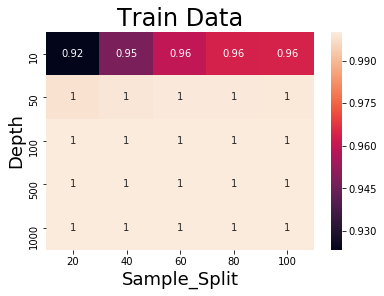

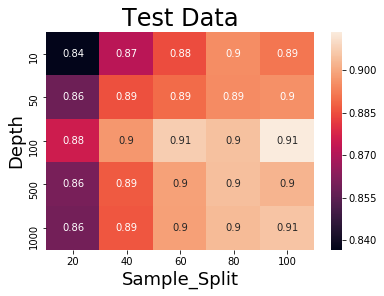

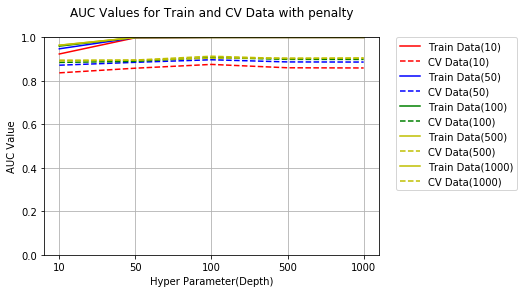

The best depth of the Tree : 100  and the best split is : 100


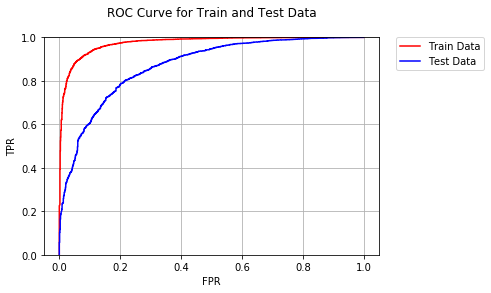

The AUC value for test data is  0.8696844069939478


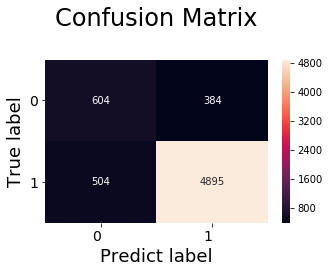

In [119]:
# Please write all the code with proper documentation
rf(X_train_bow,X_cv_bow,X_test_bow,y_train, y_cv, y_test)

### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

In [130]:
# Please write all the code with proper documentation
arf = RandomForestClassifier(class_weight = 'balanced',max_depth=100,min_samples_split=100)
arf.fit(X_train_bow,y_train)
feat = arf.feature_importances_

count_vect = CountVectorizer()
p = count_vect.fit_transform(X_train)
p = pd.DataFrame(feat.T,columns=['+ve'])
p['feature'] = count_vect.get_feature_names()

q = p.sort_values(by = '+ve',kind = 'quicksort',ascending= False)
print("Top 20  important features of positive class", np.array(q['feature'][:20]))

Top 20  important features of positive class ['great' 'not' 'love' 'loves' 'would' 'perfect' 'away' 'bad' 'best' 'good'
 'money' 'favorite' 'disappointed' 'china' 'nice' 'highly' 'worst'
 'delicious' 'trash' 'product']


In [131]:
# https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python
from wordcloud import WordCloud, STOPWORDS
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40,
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

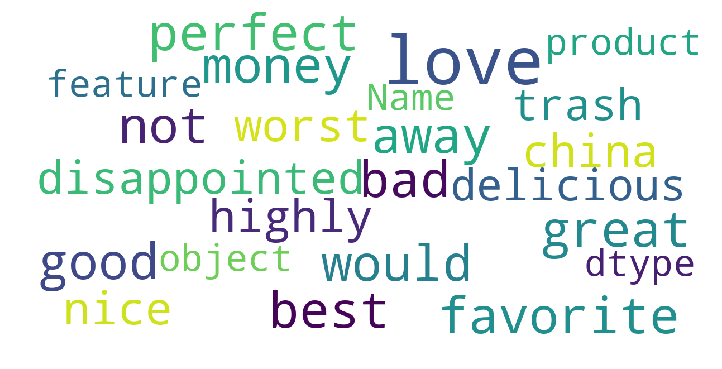

In [132]:
show_wordcloud(q['feature'][:20])

### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  1.9min finished


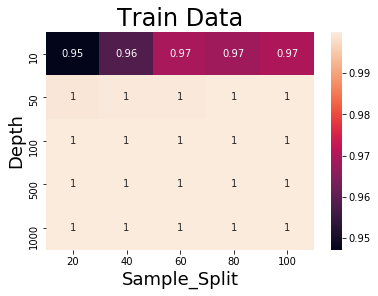

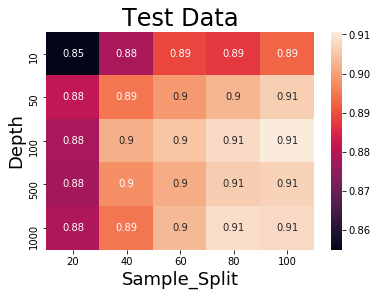

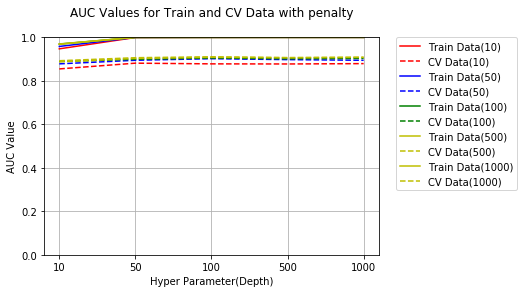

The best depth of the Tree : 100  and the best split is : 100


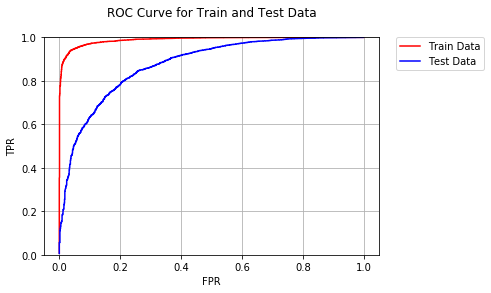

The AUC value for test data is  0.8749252935578864


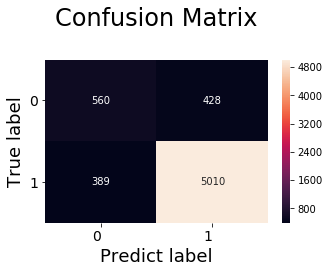

In [135]:
# Please write all the code with proper documentation
rf (X_train_tf_idf,X_cv_tf_idf,X_test_tf_idf,y_train, y_cv, y_test)

### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

In [137]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
arf = RandomForestClassifier(class_weight = 'balanced',max_depth=100,min_samples_split=100)
arf.fit(X_train_tf_idf,y_train)
feat = arf.feature_importances_

tf_idf_vector = TfidfVectorizer(ngram_range=(1,2),min_df=10)
p = tf_idf_vector.fit_transform(X_train)
p = pd.DataFrame(feat.T,columns=['+ve'])
p['feature'] = tf_idf_vector.get_feature_names()

q = p.sort_values(by = '+ve',kind = 'quicksort',ascending= False)
print("Top 20  important features of positive class", np.array(q['feature'][:20]))

Top 20  important features of positive class ['not' 'great' 'love' 'good' 'best' 'perfect' 'away' 'disappointed'
 'would' 'not buy' 'would not' 'bad' 'favorite' 'wonderful' 'highly'
 'excellent' 'loves' 'ok' 'nice' 'made']


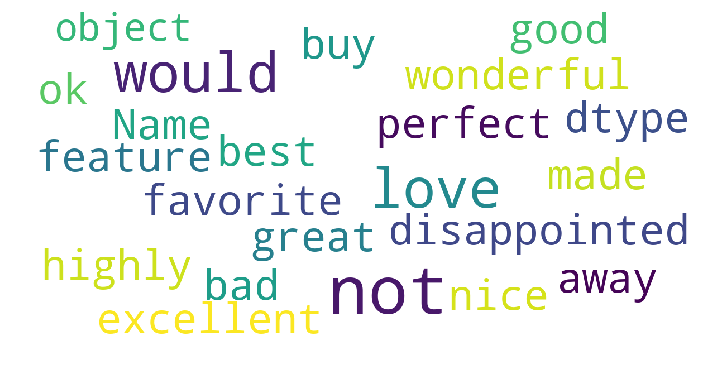

In [138]:
show_wordcloud(q['feature'][:20])

### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  1.9min finished


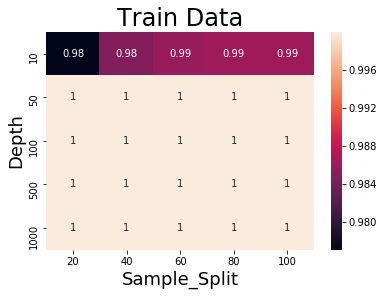

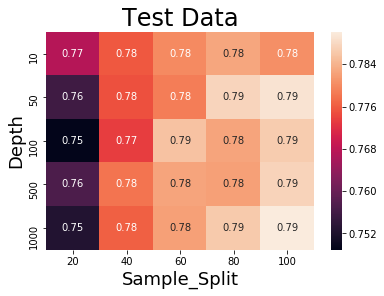

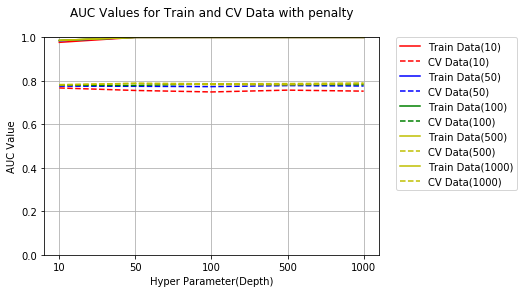

The best depth of the Tree : 1000  and the best split is : 100


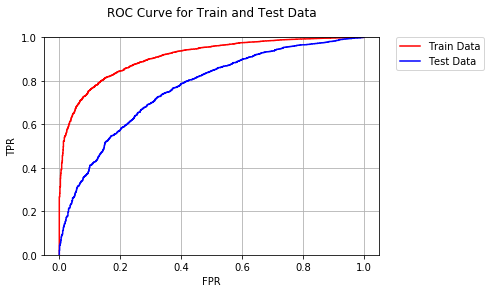

The AUC value for test data is  0.7658971934373812


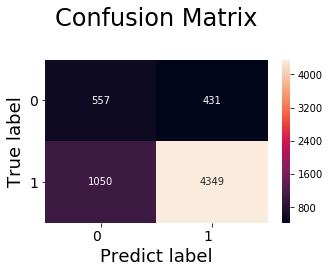

In [140]:
# Please write all the code with proper documentation
rf (sent_vectors_train,sent_vectors_cv,sent_vectors_test,y_train, y_cv, y_test)

### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  2.0min finished


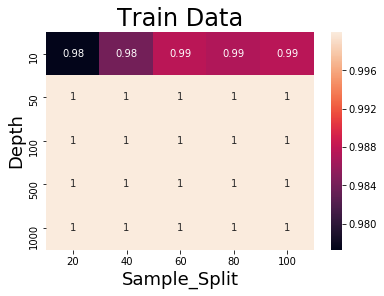

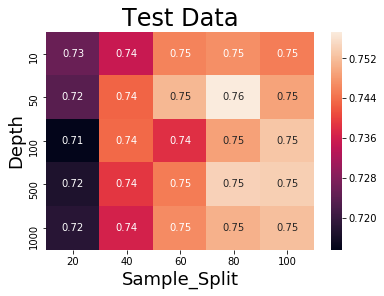

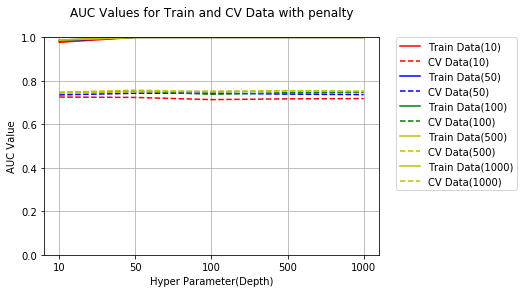

The best depth of the Tree : 50  and the best split is : 80


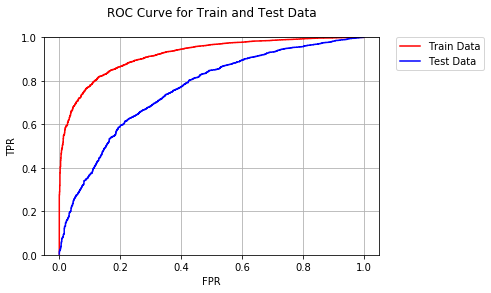

The AUC value for test data is  0.7598824343689377


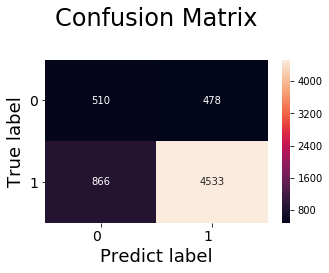

In [141]:
# Please write all the code with proper documentation
rf(tfidf_sent_vectors,tfidf_cv_sent_vectors_cv,tfidf_test_sent_vectors_test,y_train, y_cv, y_test)

## [5.2] Applying GBDT using XGBOOST

In [175]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
def gbdt(X_train_vec,X_cv_vec,X_test_vec,Y_train, Y_cv, Y_test):
    
    
    b = [50,100,200,400,500]
    d = [2,3,5,8,10]
    para = {'n_estimators':b,'max_depth':d}
    xg = xgb.XGBClassifier(class_weight = 'balanced' )
    model = GridSearchCV(xgb.XGBClassifier(),para,scoring='roc_auc',verbose=1)
    model.fit(np.array(X_train_vec),Y_train)
    best_n = model.best_params_.get('n_estimators')
    best_d = model.best_params_.get('max_depth')
    
    train_score = model.cv_results_.get('mean_train_score')
    test_score = model.cv_results_.get('mean_test_score')
    #print(train_score)
    #print(test_score)
    #Train Score
    m= pd.DataFrame(train_score.reshape(5,5),columns= b,index = d)
    sns.heatmap(m, annot=True)
    plt. ylabel('Depth' , size=18)
    plt. xlabel('Sample_Split' , size=18)
    plt. title("Train Data", size=24)
    plt. show()
    #Test Score
    m= pd.DataFrame(test_score.reshape(5,5),columns=b ,index = d)
    sns.heatmap(m, annot=True)
    plt. ylabel('Depth' , size=18)
    plt. xlabel('Sample_Split' , size=18)
    plt. title("Test Data", size=24)
    plt. show()
    
    #ploting Auc curve for train and cv
    i= np.arange(len(d))
    plt.plot(i,train_score[::5],'r', label = 'Train Data(10)')
    plt.plot(i,test_score[::5],'r--', label = 'CV Data(10)')

    plt.plot(i,train_score[1::5],'b', label = 'Train Data(50)')
    plt.plot(i,test_score[1::5],'b--', label = 'CV Data(50)')

    plt.plot(i,train_score[2::5],'g', label = 'Train Data(100)')
    plt.plot(i,test_score[2::5],'g--', label = 'CV Data(100)')

    plt.plot(i,train_score[3::5],'y', label = 'Train Data(500)')
    plt.plot(i,test_score[3::5],'y--', label = 'CV Data(500)')
    
    plt.plot(i,train_score[4::5],'y', label = 'Train Data(1000)')
    plt.plot(i,test_score[4::5],'y--', label = 'CV Data(1000)')
    
    plt.xticks(i,d)
    plt.ylim(0,1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.title("AUC Values for Train and CV Data with penalty\n")
    plt.xlabel("Hyper Parameter(Depth)")
    plt.ylabel("AUC Value")
    plt.show()
    #best_depth = model.best_params_.get('max_depth')
    #best_split = model.best_params_.get('min_samples_split')
    print("The best depth of the Tree :",best_d," and the best split is :",best_n)
    
    xgbd= xgb.XGBClassifier(class_weight = 'balanced',max_depth= best_d  ,n_estimators= best_n)
    xgbd.fit(np.array(X_train_vec),Y_train)
    
    #pred_train = dtree.predict_proba(X_train_vec)[:,1]
    #pred_test = dtree.predict_proba(X_test_vec)[:,1]
    fpr,tpr,threshold = roc_curve(Y_train,xgbd.predict_proba(np.array(X_train_vec))[:,1])
    fpr1, tpr1, threshold1 = roc_curve(Y_test,xgbd.predict_proba(np.array(X_test_vec))[:,1])
    
    plt.plot(fpr,tpr,'r', label = 'Train Data')
    plt.plot(fpr1,tpr1,'b', label = 'Test Data')
    plt.ylim(0,1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.title("ROC Curve for Train and Test Data\n")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()
    
    print("The AUC value for test data is ",roc_auc_score( Y_test,xgbd.predict_proba(np.array(X_test_vec))[:,1]))
    
    #Confusion Matrix
    cm = confusion_matrix(Y_test,xgbd.predict(np.array(X_test_vec)))
    tn, fp, fn, tp = cm.ravel()

    # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    # Code for drawing seaborn heatmaps
    class_names = ['0','1']
    df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
    fig = plt.figure(figsize=(5,3))
    heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

    # Setting tick labels for heatmap
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    plt.ylabel('True label',size=18)
    plt.xlabel('Predict label',size=18)
    plt.title("Confusion Matrix\n",size=24)
    plt.show()
    

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 24.5min finished


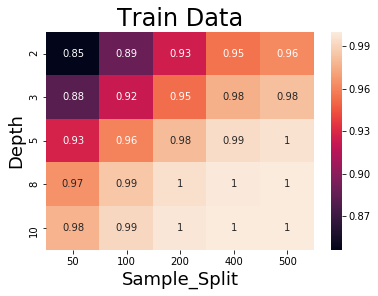

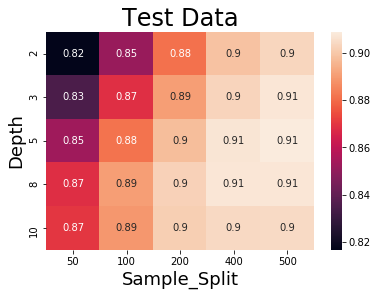

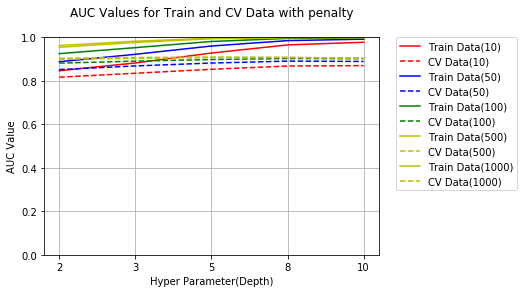

The best depth of the Tree : 5  and the best split is : 500


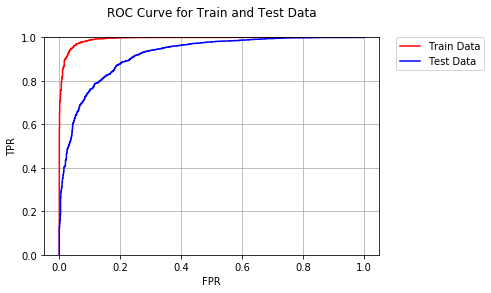

The AUC value for test data is  0.9196189615260887


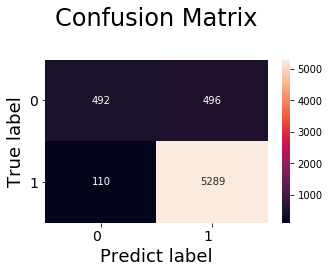

In [144]:
# Please write all the code with proper documentation
gbdt(X_train_bow,X_cv_bow,X_test_bow,y_train, y_cv, y_test)

### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 20.0min finished


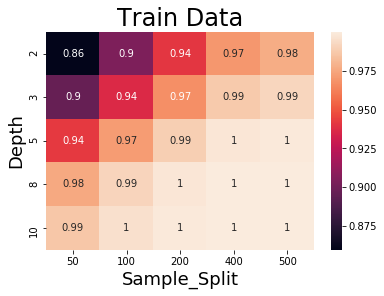

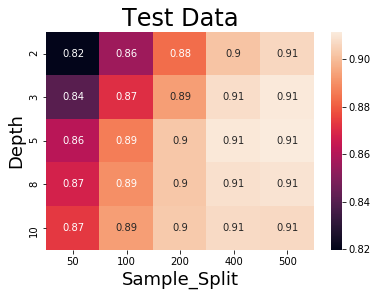

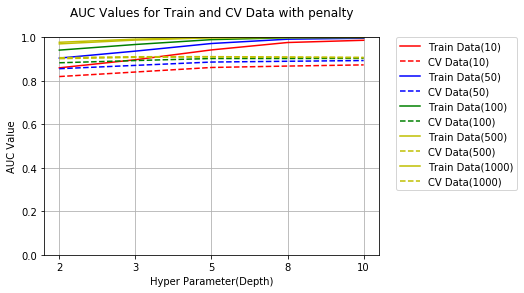

The best depth of the Tree : 5  and the best split is : 500


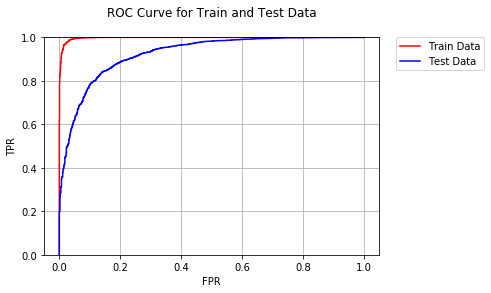

The AUC value for test data is  0.9243757091019255


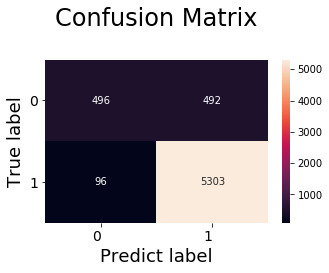

In [145]:
# Please write all the code with proper documentation
gbdt(X_train_tf_idf,X_cv_tf_idf,X_test_tf_idf,y_train, y_cv, y_test)

### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 13.7min finished


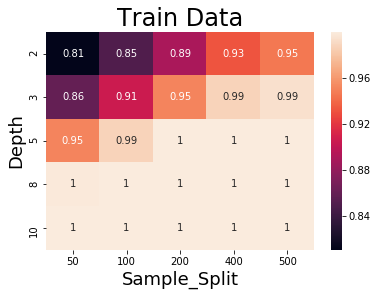

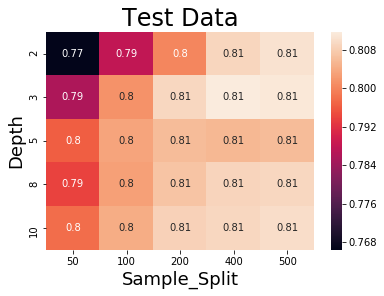

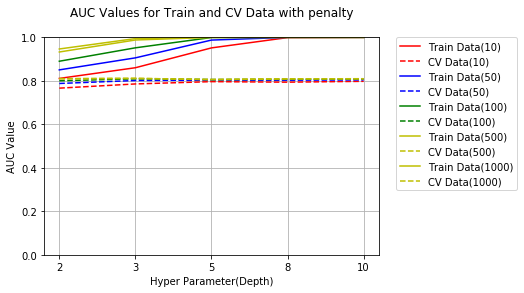

The best depth of the Tree : 3  and the best split is : 400


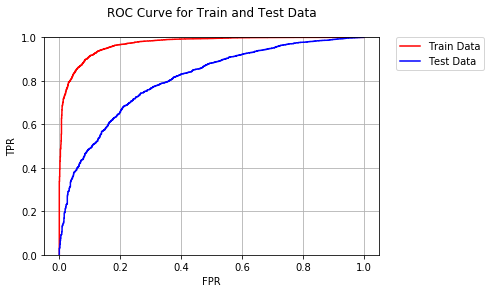

The AUC value for test data is  0.8064990667787482


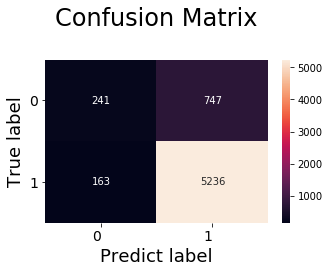

In [146]:
# Please write all the code with proper documentation
gbdt(sent_vectors_train,sent_vectors_cv,sent_vectors_test,y_train, y_cv, y_test)

### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 13.3min finished


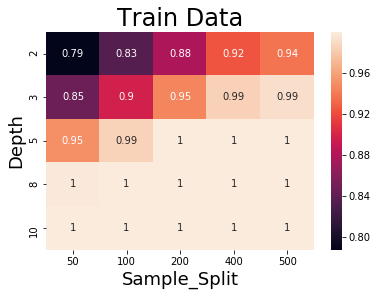

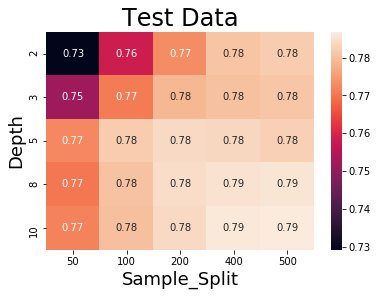

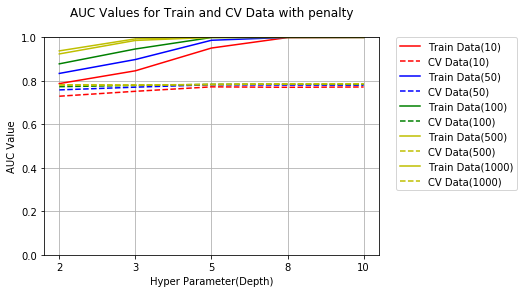

The best depth of the Tree : 10  and the best split is : 500


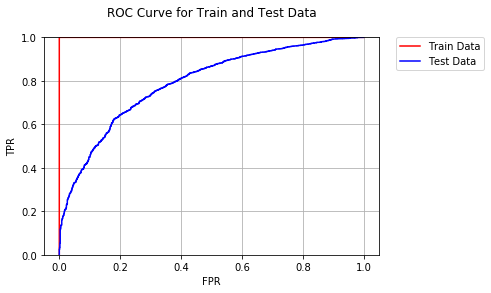

The AUC value for test data is  0.7911924947864839


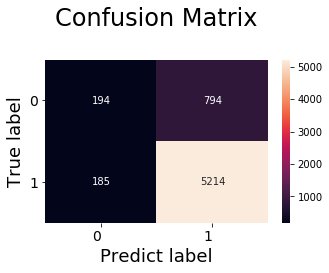

In [176]:
# Please write all the code with proper documentation
gbdt(tfidf_sent_vectors,tfidf_cv_sent_vectors_cv,tfidf_test_sent_vectors_test,y_train, y_cv, y_test)

# [6] Conclusions

In [178]:
# Please compare all your models using Prettytable library
from prettytable import from_csv
with open("table.csv", "r") as fp: 
    x = from_csv(fp)
    
print(x)

+---------------+---------------+--------------+-----------+------+
| ï»¿Vectorizer |     Method    | n_estimators | Max_depth | AUC  |
+---------------+---------------+--------------+-----------+------+
|      BOW      | Random Forest |     100      |    100    | 0.86 |
|     TF-IDF    | Random Forest |     100      |    100    | 0.87 |
|     W2VEC     | Random Forest |     100      |    100    | 0.76 |
|  TF-IDF W2VEC | Random Forest |      50      |     80    | 0.75 |
|      BOW      |    XGBOOST    |     500      |     5     | 0.91 |
|     TF-IDF    |    XGBOOST    |     500      |     5     | 0.92 |
|     W2VEC     |    XGBOOST    |     400      |     3     | 0.8  |
|  TF-IDF W2VEC |    XGBOOST    |     500      |     10    | 0.79 |
+---------------+---------------+--------------+-----------+------+


1) We got Higest AUC value of -- in 

2) From the above AUC values we can state that XGBOOST performs better than the Random forest

3) XGboost takes more run time than the Randomforest

4) By considering more data points and features we can improve the performance of the model, since the run time is high we limited our observation to 20k data points
